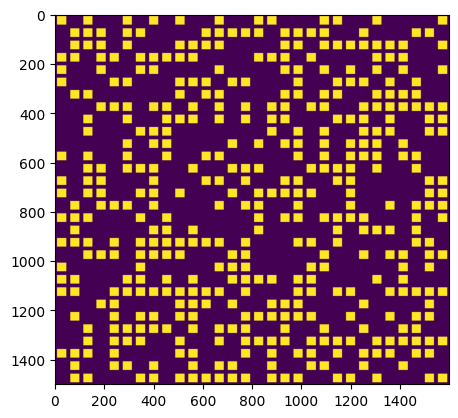

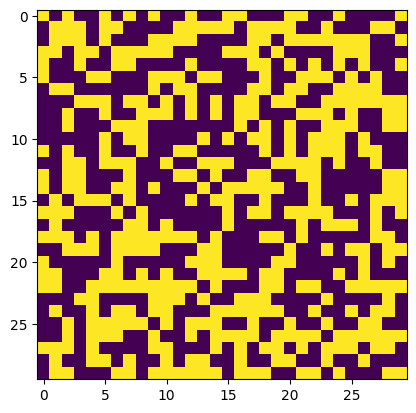

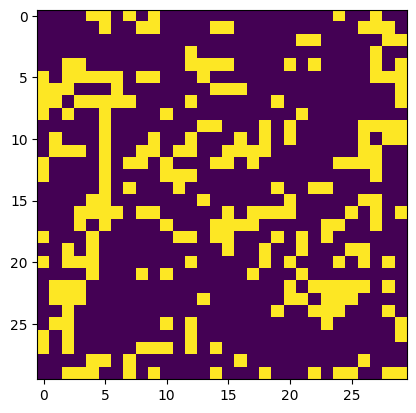

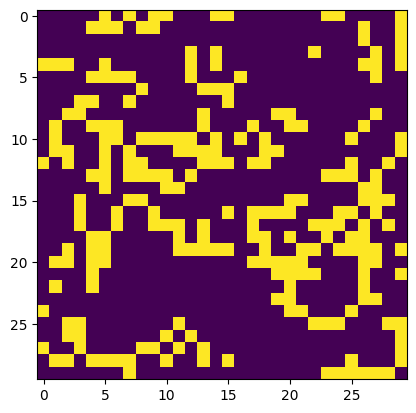

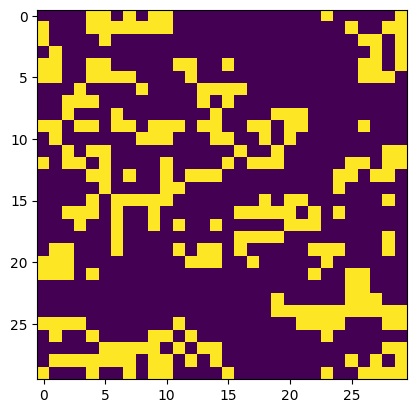

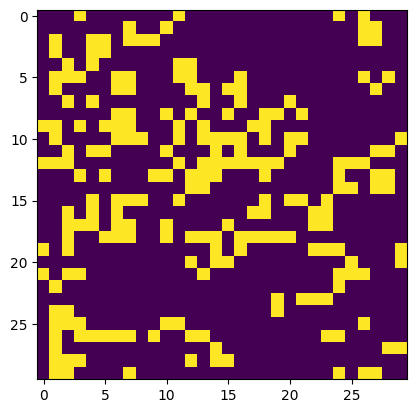

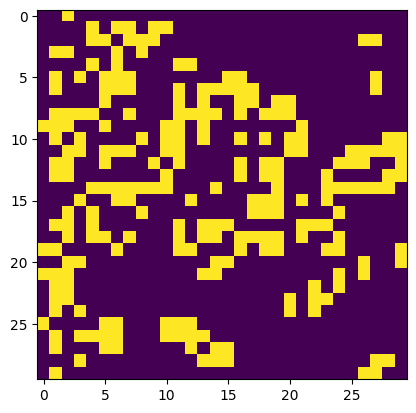

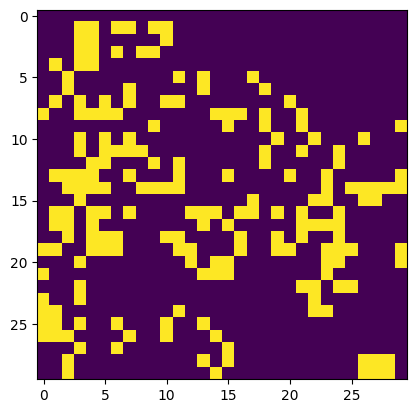

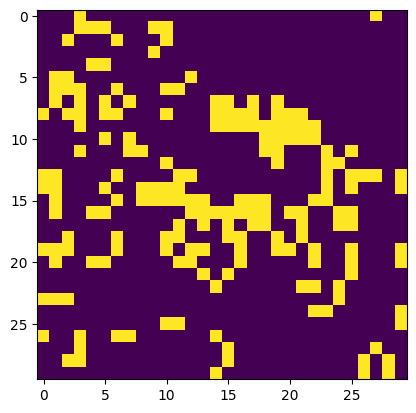

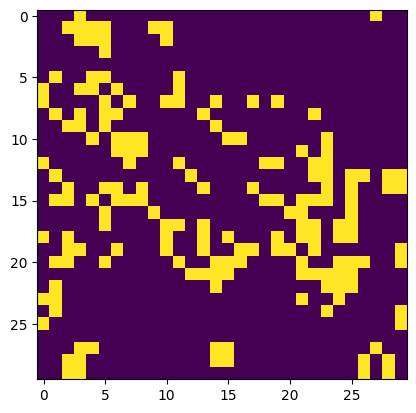

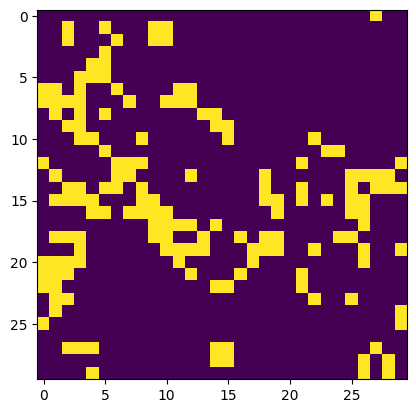

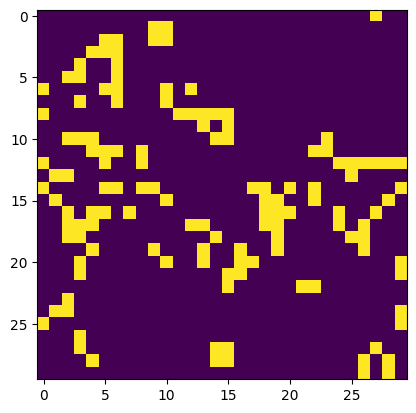

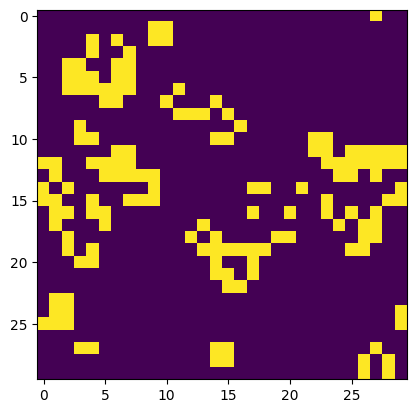

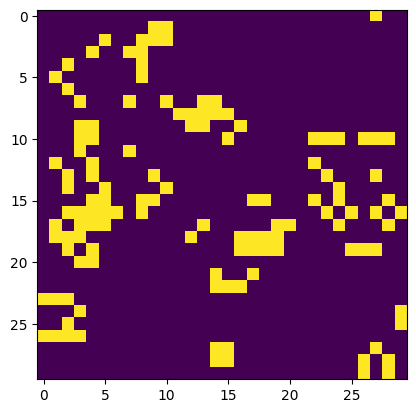

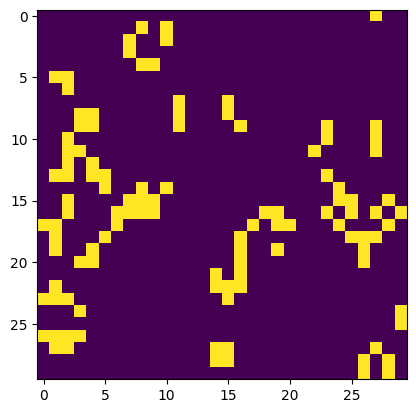

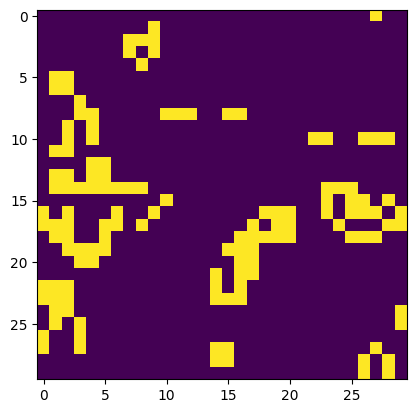

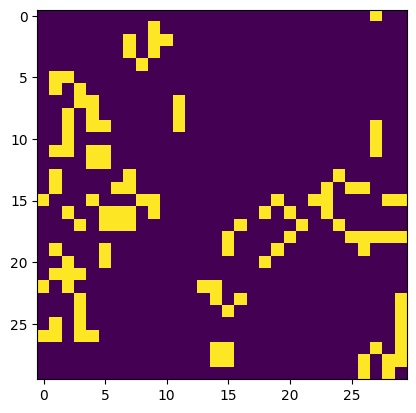

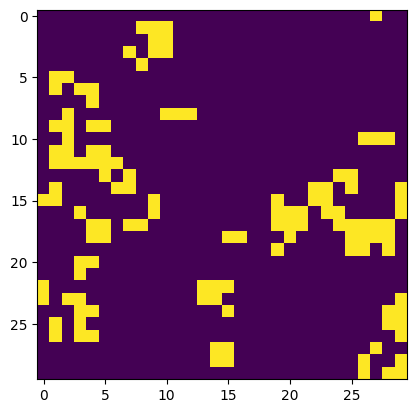

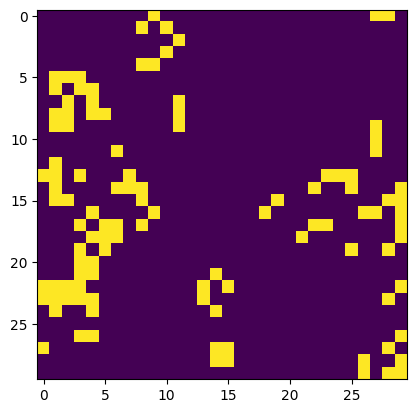

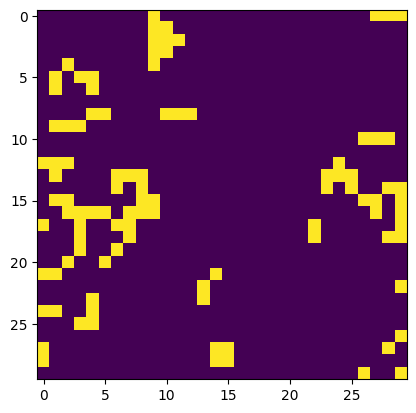

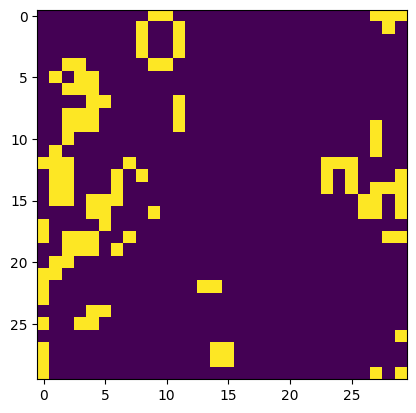

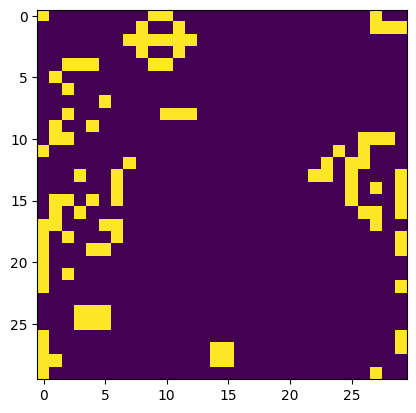

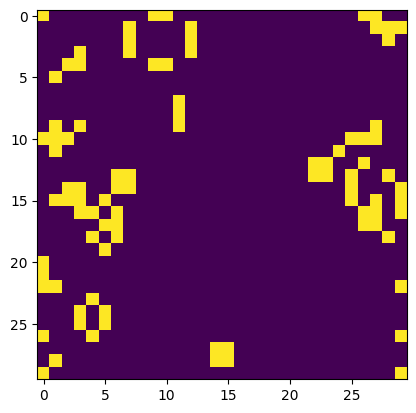

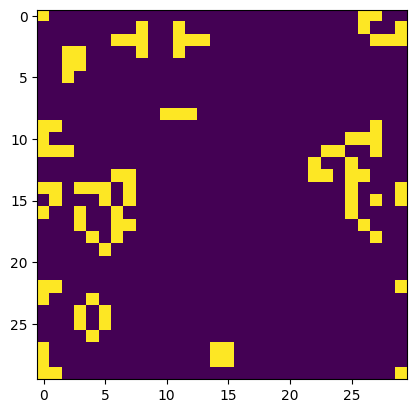

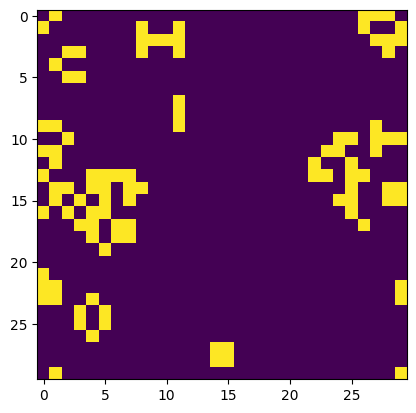

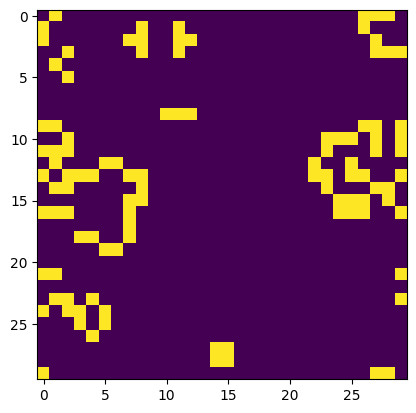

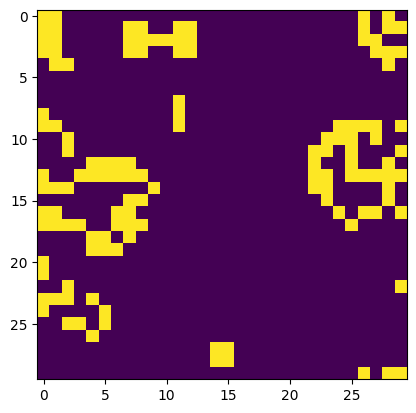

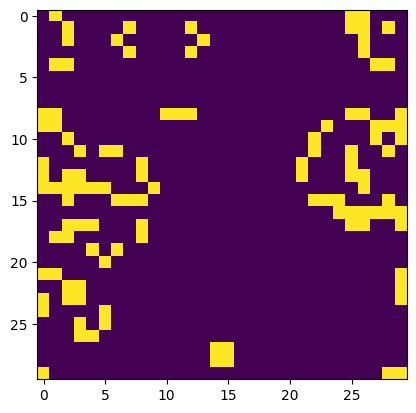

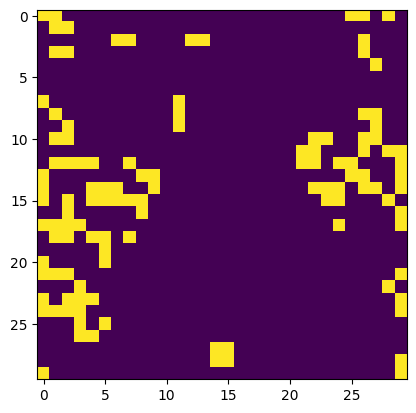

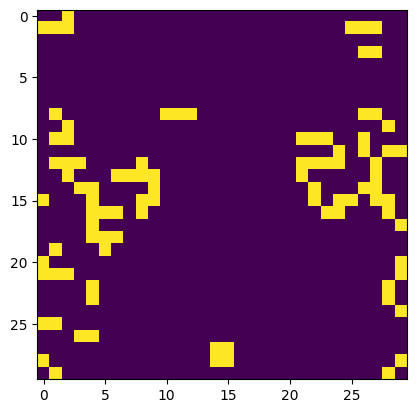

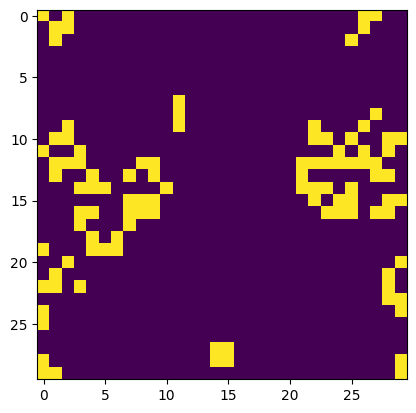

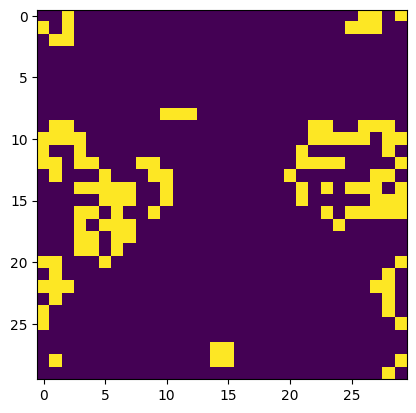

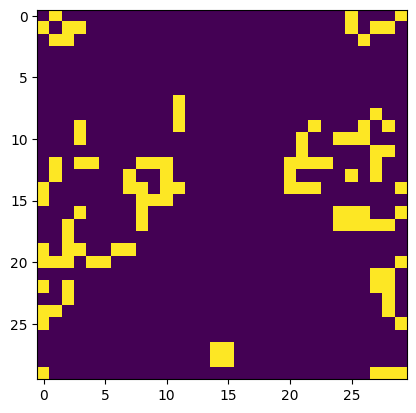

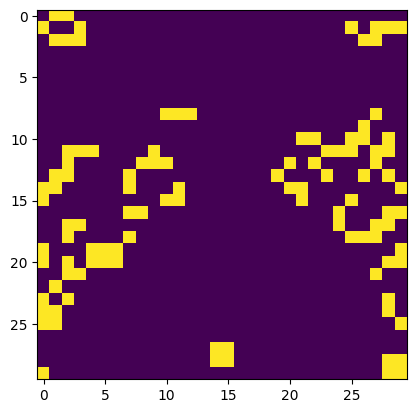

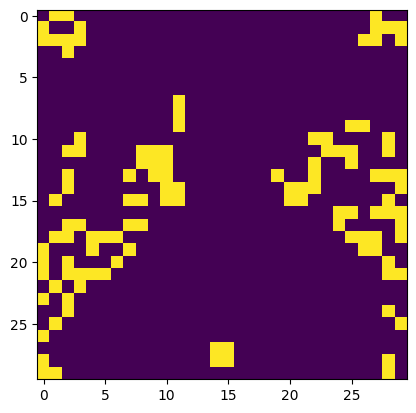

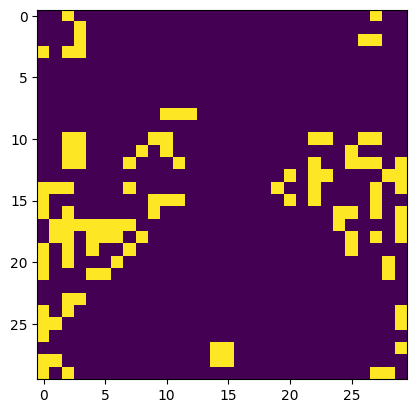

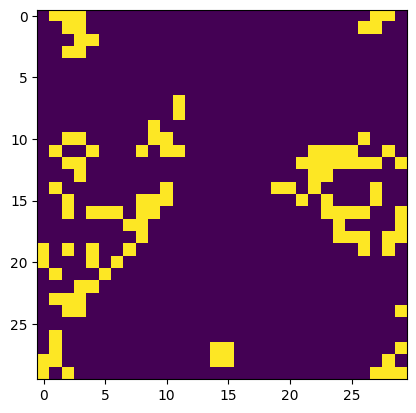

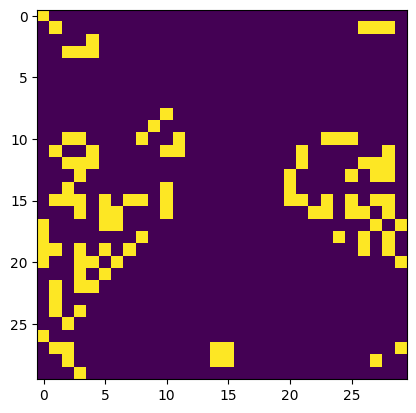

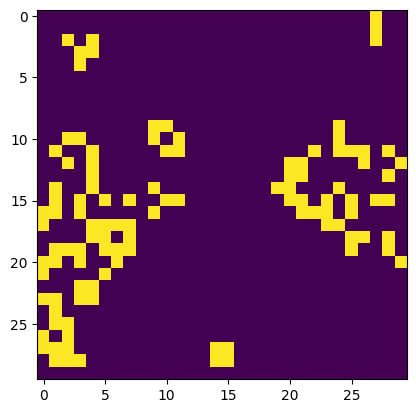

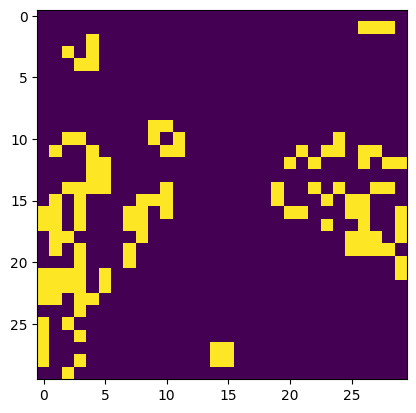

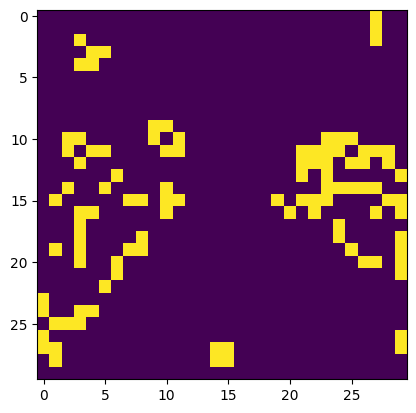

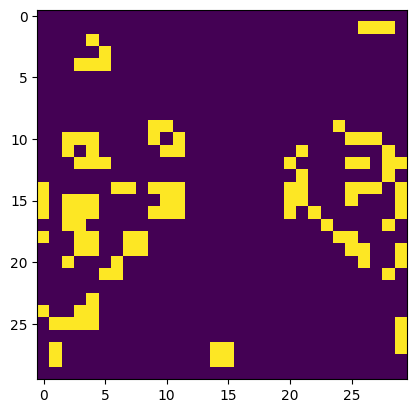

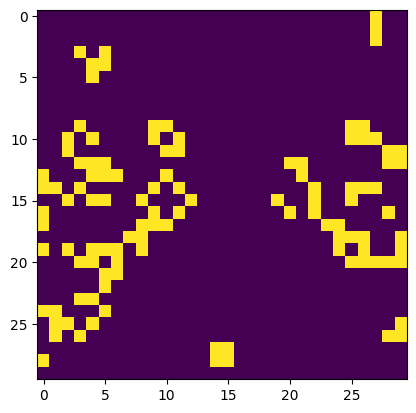

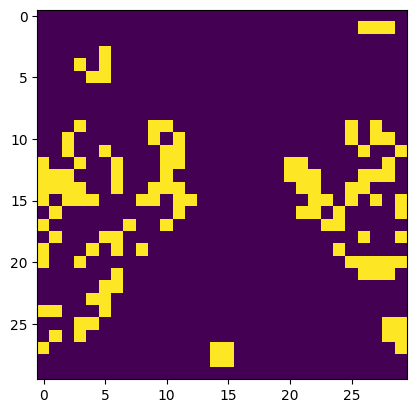

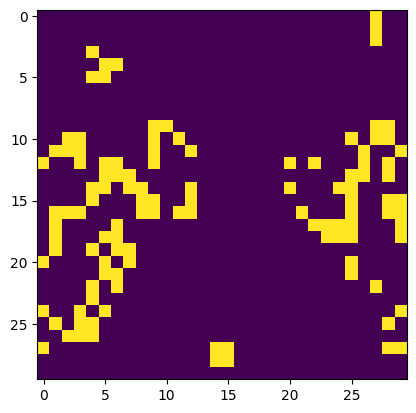

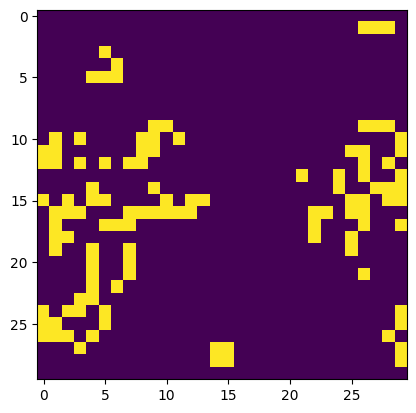

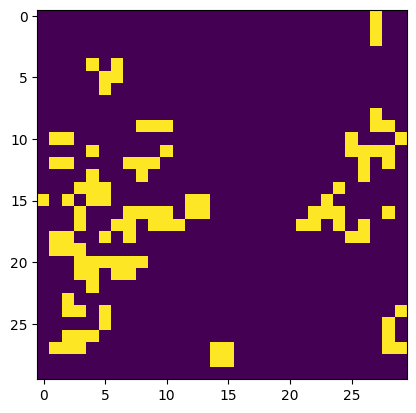

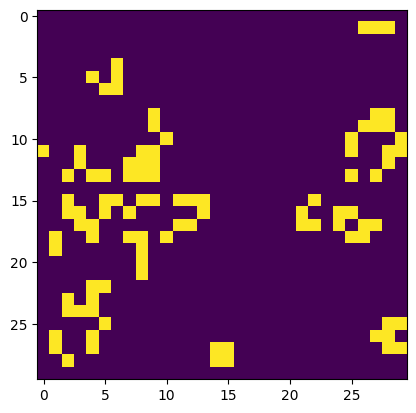

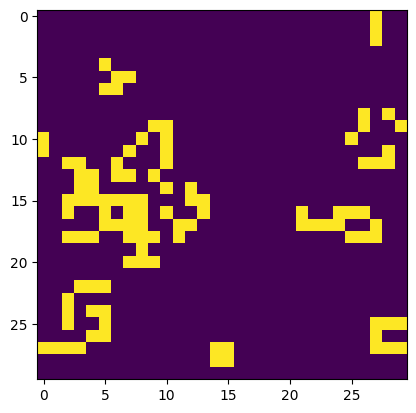

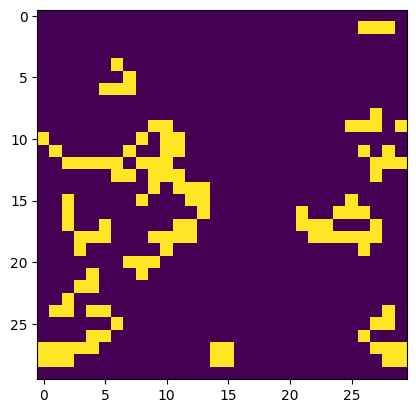

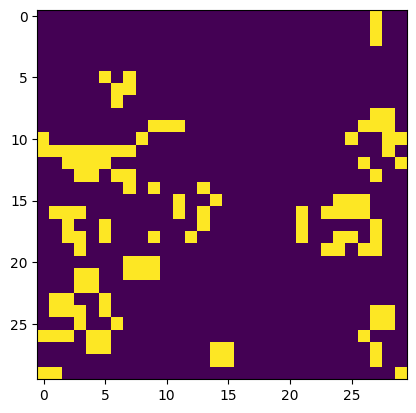

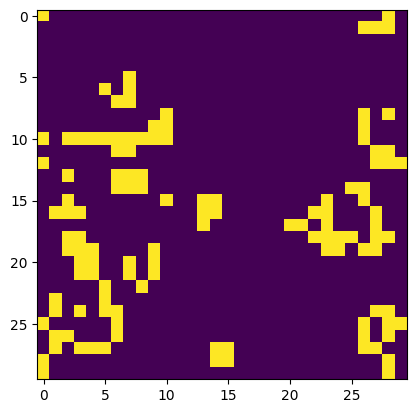

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.lib import is_valid


def grid_to_image(image_shape, grid_shape, diameter_ratio):
    h, w = image_shape
    rows, cols = grid_shape

    # pixel coordinates
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    bin_height = h / rows
    bin_width = w / cols

    x_bin = (xx // bin_width).astype(int)
    y_bin = (yy // bin_height).astype(int)

    # fractional position inside each bin
    x_border_value = (xx % bin_width) / bin_width
    y_border_value = (yy % bin_height) / bin_height

    edge_width = (1 - diameter_ratio) / 2

    is_border_x = (x_border_value < edge_width) | (x_border_value > (1 - edge_width))
    is_border_y = (y_border_value < edge_width) | (y_border_value > (1 - edge_width))
    is_border = is_border_x | is_border_y

    # mask to keep only interior pixels
    valid = ~is_border

    return x_bin, y_bin, valid

def generate_image_from_grid(grid: np.ndarray, diameter_ratio=0.7):

    h, w = (1500, 1599)

    x_bin, y_bin, valid = grid_to_image((h, w), grid.shape, diameter_ratio)

    bin_value = grid[y_bin, x_bin]

    return valid * bin_value

def avg_grid_values_from_image(image, diameter_ratio):

    rows, cols = (30, 30)

    x_bin, y_bin, valid = grid_to_image(image.shape, (rows, cols), diameter_ratio)

    flat_bins = y_bin * cols + x_bin
    flat_bins = flat_bins[valid]
    flat_image = image[valid]

    # accumulate sums and counts
    sums = np.bincount(flat_bins, weights=flat_image, minlength=rows * cols)
    counts = np.bincount(flat_bins, minlength=rows * cols)

    # avoid divide-by-zero
    grid = np.zeros(rows * cols)
    nonzero = counts > 0
    grid[nonzero] = sums[nonzero] / counts[nonzero]

    return grid.reshape(rows, cols)

def advance_gol(grid: np.ndarray):
    """
    implements game of life rules:
    cells are either dead or alive
    a live cell with less than 2 neighbors dies by underpopulation
    a live cell with more than 3 neighbors dies by overpopulation
    a live cell with 2-3 neighbors stays alive
    a dead cell with exactly 3 neighbors is born

    takes current state and returns the next state
    """

    padded = np.pad(grid, (1, 1), mode="wrap")

    num_neighbors = np.zeros_like(grid)

    for h in (0, 1, 2):
        for w in (0, 1, 2):
            if h == 1 and w == 1:
                continue
            num_neighbors += padded[h:padded.shape[0] - (2 - h), w:padded.shape[1] - (2 - w)]

    born = (1 - grid) * (num_neighbors == 3)
    alive = grid * (num_neighbors >= 2) * (num_neighbors <= 3)

    return alive + born

image = generate_image_from_grid(np.random.choice([0, 1], (30, 30), True))
plt.imshow(image)
plt.show()

grid = avg_grid_values_from_image(image, 0.7)
plt.imshow(grid)
plt.show()

for i in range(50):
    grid = advance_gol(grid)
    plt.imshow(grid)
    plt.show()
